In [32]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
stop =stopwords.words('english')
import matplotlib.pyplot as plt
import string
punctuation = string.punctuation
from collections import Counter
import itertools
import datetime
import emoji
from nltk.stem.porter import PorterStemmer
nltk.download('words')
datetime.datetime.now()
words = set(nltk.corpus.words.words())
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package words to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


In [33]:
#Function to remove columns
def remove_unwanted_cols(dataset, cols):
    for col in cols:
        del dataset[col]
    return dataset

DATA EXPLORATION AND PREPROCESSING - REPUBLICAN DATASET

In [34]:
path = "C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/BERT training/ExtractedTweets_GitHub_GroundofTruth.csv"
df= pd.read_csv(path,sep=",")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86460 entries, 0 to 86459
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Party   86460 non-null  object
 1   Handle  86460 non-null  object
 2   Tweet   86460 non-null  object
dtypes: object(3)
memory usage: 2.0+ MB


In [35]:
df = df.drop_duplicates(subset=['Tweet'])

In [36]:
df = df.loc[df['Party']=='Republican']

In [37]:
df['Party'].value_counts()

Republican    43388
Name: Party, dtype: int64

In [38]:
#TAKE INTO CONSIDERATION ONLY THE TEXTS WITH MORE THAN 6 WORDS
df['length'] = df['Tweet'].apply(lambda x: len(x))
cond = df['length'] > 6
df = df[cond]
df = remove_unwanted_cols(df, ['length'])

In [39]:
df['Target'] = 0

TEXT CLEANING

In [40]:
#Funzione di preprocessing:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words] 
    return " ".join(filtered_words)
df['Text_clean'] = df['Tweet'].apply(preprocess_tweet_text)

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"# flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
df['Text_clean'] = df['Text_clean'].apply(deEmojify)

def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet

df['Text_clean'] = df['Text_clean'].map(lambda x: cleaner(x))

In [41]:
df['Text_cleanEDA'] = df['Text_clean']

#eyes, nose and mouth 
emoticons_str = r"""
    (?:
        [:=;] 
        [oO\-]? 
        [D\)\]\(\]/\\OpP] 
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
    r"\U0001F600-\U0001F64F"  # emoticons
    r"\U0001F300-\U0001F5FF"  # symbols & pictographs
    r"\U0001F680-\U0001F6FF"  # transport & map symbols
    r"\U0001F1E0-\U0001F1FF"  #flags
    r"\U00002702-\U000027B0"
    r"\U000024C2-\U0001F251"# flags (iOS) 
    r"\U0001f926-\U0001f937"
    r"\U00010000-\U0010ffff"
    r"\u2640-\u2642"
    r"\u2600-\u2B55"
    r"\u200d"
    r"\u23cf"
    r"\u23e9"
    r"\u231a"
    r"\ufe0f"  # dingbats
    r"\u3030"
]
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
df['Text_cleanEDA'] = df['Text_cleanEDA'].apply(preprocess) 

import string
punctuation = string.punctuation

def preprocess(tokenized_sentence):
  tokenized_sentence_stop = [item.lower() for item in tokenized_sentence if item.lower() not in stop] #remove stopwords
  return [item for item in tokenized_sentence_stop if item not in punctuation] #remove punctuation 

df['Text_cleanEDA'] = df['Text_cleanEDA'].apply(preprocess)

#AGGIUNGIAMO MANUALMENTE ALCUNE PUNTEGGIATURE DA RIMUOVERE (MOLTO IMPORTANTE PERCHE' I CODICI NON SEMPRE TOLGONO TUTTO 
#ED AGGIUNGERE)
#N.B. CONVIENE FARE DEI COPIA INCOLLA DIRETTAMENTE DAI TOKEN PERCHE' SPESSO I CARATTERI VENGNO RILEVATI IN MODO DIVERSO
stop = set(stop)
stop.add("rt")
stop.add("…")
stop.add("n")
stop.add("’".lower())
stop.add("🇺")
stop.add("s")
stop.add("S".lower())
stop.add("nstay".lower())
stop.add(":/")
stop.add("nhttps".lower())
stop.add("https".lower())
stop.add("I")
stop.add("The")
stop.add("“")
stop.add("”")
stop.add("u")
stop.add("🇸")
stop.add("e")
stop.add("n")
stop.add("o")
stop.add("t")
stop.add("r")


stop = list(stop)
print(stop)

import string
punctuation = string.punctuation

def preprocess(tokenized_sentence):
  tokenized_sentence_stop = [item.lower() for item in tokenized_sentence if item.lower() not in stop] #remove stopwords
  return [item for item in tokenized_sentence_stop if item not in punctuation] #remove punctuation 

df['Text_cleanEDA'] =df['Text_cleanEDA'].apply(preprocess)

[':/', 'weren', 'she', 'of', 'while', 'her', 'for', 'that', 'has', 'some', "weren't", 'n', 't', 'should', "you're", 'll', 'it', 'more', 'can', 'ain', 'ma', "mightn't", 'are', 'by', 'himself', 'before', 'above', 'own', 'yourselves', 'having', 'until', "aren't", "mustn't", 'this', 'shouldn', 'am', "didn't", "shan't", 'how', 'these', 'down', 'have', 'did', 'couldn', 'them', "wasn't", 'isn', 'wouldn', 'themselves', '…', 'or', 'hers', "haven't", 'a', 'not', 'theirs', 'myself', 'when', 'further', 'about', 'after', 'o', 'didn', 'against', 'here', "couldn't", '“', 'and', 're', 'his', 'if', 'r', "you'd", 'at', 'ours', 'y', 'as', "wouldn't", 'nhttps', 'mightn', 'was', 'the', "it's", 'to', 'in', 'over', 'from', '”', 'both', 'won', 'doesn', 'been', 'what', 'herself', 'hasn', 'why', 'nor', 'hadn', 'our', 'yourself', 'its', 'haven', "you've", 'out', 'such', 'aren', 'he', 'under', 'but', 'few', 'https', 'you', 'whom', 'below', "you'll", 'only', 'mustn', 'doing', 'most', 'same', 'with', 'where', 'so',

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43387 entries, 42068 to 86459
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Party          43387 non-null  object
 1   Handle         43387 non-null  object
 2   Tweet          43387 non-null  object
 3   Target         43387 non-null  int64 
 4   Text_clean     43387 non-null  object
 5   Text_cleanEDA  43387 non-null  object
dtypes: int64(1), object(5)
memory usage: 2.3+ MB


In [43]:
import string
punctuation = string.punctuation
def preprocess(tokenized_sentence):
  tokenized_sentence_stop = [item.lower() for item in tokenized_sentence if item.lower() not in stop] #remove stopwords
  return [item for item in tokenized_sentence_stop if item not in punctuation] #remove punctuation 
df['Text_cleanEDA'] = df['Text_cleanEDA'].apply(preprocess)

In [44]:
Republican_tweets = df.loc[df['Target']==0]

[(0.0, 5000.0),
 Text(0.5, 0, 'Token frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Republican Tweets')]

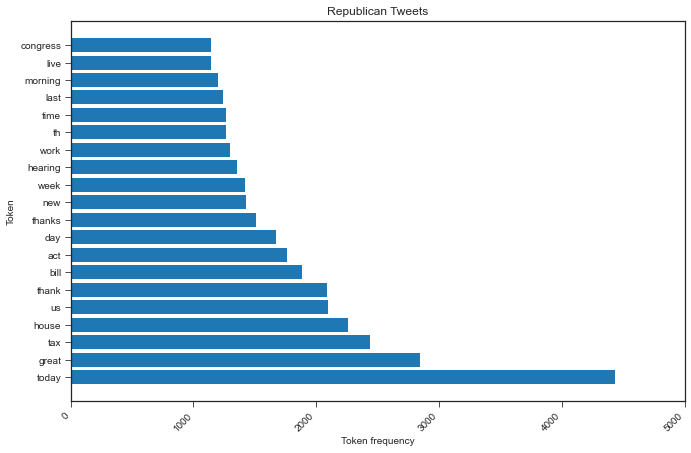

In [45]:
sentences = (list(itertools.chain(Republican_tweets['Text_cleanEDA'])))
flat_list = [item for sublist in sentences for item in sublist]
flat_list[:30]

c = Counter(flat_list)
list_common_tokens_dem = c.most_common(20)
list_common_tokens_dem
common_tokens = pd.DataFrame(list_common_tokens_dem, columns=['Token','Frequency'])
fig, ax = plt.subplots(figsize=(11, 7))
ax.barh(common_tokens['Token'], common_tokens['Frequency'])
labels = ax.get_xticklabels()
plt.style.use('seaborn-ticks')
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[0, 5000], xlabel='Token frequency', ylabel='Token',
       title='Republican Tweets')

DATA EXPLORATION AND PREPROCESSING - ANTI TRUMP

In [46]:
path = "C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/BERT training/trump_insult_tweets_2014_to_2021.csv"
df_antitrump= pd.read_csv(path,sep=",")
#REMOVE USELESS COLUMNS
df_antitrump = remove_unwanted_cols(df_antitrump, ['Unnamed: 0','date', 'target','insult'])
#DROP DUPLICATES
df_antitrump.drop_duplicates(subset=['tweet'], inplace=True)
df_antitrump.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5673 entries, 0 to 10359
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   5673 non-null   object
dtypes: object(1)
memory usage: 88.6+ KB


In [47]:
#Funzione di preprocessing:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words] 
    return " ".join(filtered_words)
df_antitrump['Text_clean'] = df_antitrump['tweet'].apply(preprocess_tweet_text)

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF" 
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"# flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
df_antitrump['Text_clean'] = df_antitrump['Text_clean'].apply(deEmojify)

def cleaner(tweet):
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = " ".join(w for w in nltk.wordpunct_tokenize(tweet) \
         if w.lower() in words or not w.isalpha())
    return tweet

df_antitrump['Text_clean'] = df_antitrump['Text_clean'].map(lambda x: cleaner(x))
df_antitrump['Text_cleanEDA'] = df_antitrump['Text_clean']

#eyes, nose and mouth 
emoticons_str = r"""
    (?:
        [:=;] 
        [oO\-]? 
        [D\)\]\(\]/\\OpP] 
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
    r"\U0001F600-\U0001F64F"  # emoticons
    r"\U0001F300-\U0001F5FF"  # symbols & pictographs
    r"\U0001F680-\U0001F6FF"  # transport & map symbols
    r"\U0001F1E0-\U0001F1FF"  #flags
    r"\U00002702-\U000027B0"
    r"\U000024C2-\U0001F251"# flags (iOS) 
    r"\U0001f926-\U0001f937"
    r"\U00010000-\U0010ffff"
    r"\u2640-\u2642"
    r"\u2600-\u2B55"
    r"\u200d"
    r"\u23cf"
    r"\u23e9"
    r"\u231a"
    r"\ufe0f"  # dingbats
    r"\u3030"
]
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
 
def tokenize(s):
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens
df_antitrump['Text_cleanEDA'] = df_antitrump['Text_cleanEDA'].apply(preprocess) 

import string
punctuation = string.punctuation

def preprocess(tokenized_sentence):
  tokenized_sentence_stop = [item.lower() for item in tokenized_sentence if item.lower() not in stop] #remove stopwords
  return [item for item in tokenized_sentence_stop if item not in punctuation] #remove punctuation 

df_antitrump['Text_cleanEDA'] = df_antitrump['Text_cleanEDA'].apply(preprocess)

#AGGIUNGIAMO MANUALMENTE ALCUNE PUNTEGGIATURE DA RIMUOVERE (MOLTO IMPORTANTE PERCHE' I CODICI NON SEMPRE TOLGONO TUTTO 
#ED AGGIUNGERE)
#N.B. CONVIENE FARE DEI COPIA INCOLLA DIRETTAMENTE DAI TOKEN PERCHE' SPESSO I CARATTERI VENGNO RILEVATI IN MODO DIVERSO
stop = set(stop)
stop.add("rt")
stop.add("…")
stop.add("n")
stop.add("’".lower())
stop.add("🇺")
stop.add("s")
stop.add("S".lower())
stop.add("nstay".lower())
stop.add(":/")
stop.add("nhttps".lower())
stop.add("https".lower())
stop.add("I")
stop.add("The")
stop.add("“")
stop.add("”")
stop.add("u")
stop.add("🇸")
stop.add("e")
stop.add("n")
stop.add("o")
stop.add("t")
stop.add("r")
stop = list(stop)
print(stop)

import string
punctuation = string.punctuation
def preprocess(tokenized_sentence):
  tokenized_sentence_stop = [item.lower() for item in tokenized_sentence if item.lower() not in stop] #remove stopwords
  return [item for item in tokenized_sentence_stop if item not in punctuation] #remove punctuation 
df_antitrump['Text_cleanEDA'] = df_antitrump['Text_cleanEDA'].apply(preprocess)

[':/', 'weren', 'she', 'of', 'while', 'her', 'some', 'n', "weren't", 'has', 'for', 'that', 't', 'should', "you're", 'll', 'it', 'more', 'can', 'ain', 'ma', "mightn't", 'are', 'by', 'himself', 'before', 'above', 'own', 'yourselves', 'having', 'until', "aren't", "mustn't", 'this', 'shouldn', 'am', "didn't", "shan't", 'how', 'these', 'down', 'have', 'did', 'couldn', 'them', "wasn't", 'isn', 'wouldn', '…', 'themselves', 'or', 'hers', "haven't", 'a', 'not', 'theirs', 'myself', 'when', 'further', 'about', 'after', 'o', 'didn', 'against', 'here', "couldn't", '“', 'and', 're', 'his', 'if', 'r', "you'd", 'at', 'ours', 'y', 'as', "wouldn't", 'nhttps', 'mightn', 'was', 'the', "it's", 'to', 'in', 'over', 'from', '”', 'both', 'won', 'doesn', 'been', 'what', 'herself', 'hasn', 'why', 'nor', 'hadn', 'our', 'yourself', 'its', 'haven', "you've", 'out', 'such', 'aren', 'he', 'under', 'but', 'few', 'https', 'you', 'whom', 'below', "you'll", 'only', 'mustn', 'doing', 'most', 'same', 'with', 'where', 'so',

In [48]:
import string
punctuation = string.punctuation
def preprocess(tokenized_sentence):
  tokenized_sentence_stop = [item.lower() for item in tokenized_sentence if item.lower() not in stop] #remove stopwords
  return [item for item in tokenized_sentence_stop if item not in punctuation] #remove punctuation 
df_antitrump['Text_cleanEDA'] = df_antitrump['Text_cleanEDA'].apply(preprocess)

[(0.0, 5000.0),
 Text(0.5, 0, 'Token frequency'),
 Text(0, 0.5, 'Token'),
 Text(0.5, 1.0, 'Anti Trump Tweets')]

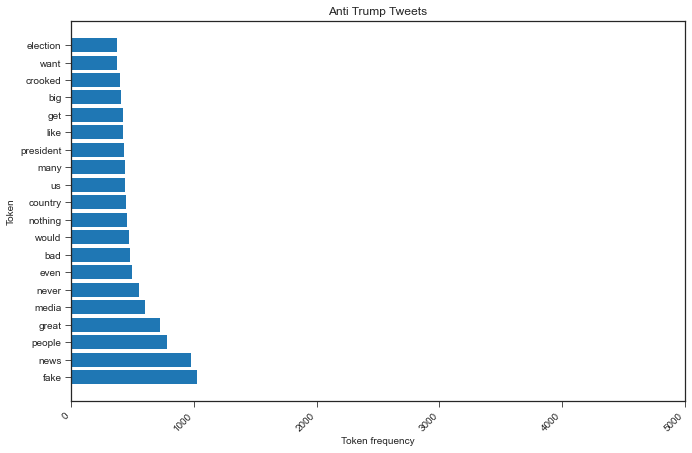

In [49]:
sentences = (list(itertools.chain(df_antitrump['Text_cleanEDA'])))
flat_list = [item for sublist in sentences for item in sublist]
flat_list[:30]

c = Counter(flat_list)
list_common_tokens_dem = c.most_common(20)
list_common_tokens_dem
common_tokens = pd.DataFrame(list_common_tokens_dem, columns=['Token','Frequency'])
fig, ax = plt.subplots(figsize=(11, 7))
ax.barh(common_tokens['Token'], common_tokens['Frequency'])
labels = ax.get_xticklabels()
plt.style.use('seaborn-ticks')
plt.setp(labels, rotation=45, horizontalalignment='right')
ax.set(xlim=[0, 5000], xlabel='Token frequency', ylabel='Token',
       title='Anti Trump Tweets')

CREATE DATASET TO TRAIN

In [50]:
df_antitrump['Target'] = 1

In [51]:
df = remove_unwanted_cols(df, ['Party', 'Handle','Tweet','Text_cleanEDA'])
df_antitrump = remove_unwanted_cols(df_antitrump, ['tweet','Text_cleanEDA'])

In [52]:
df_antitrump = df_antitrump[['Target', 'Text_clean']]
df = pd.concat([df,df_antitrump])

BERT

In [53]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler

In [54]:
#ANTI TRUMP 1
#PRO TRUMP 0
df['Target'].value_counts()

0    43387
1     5673
Name: Target, dtype: int64

In [55]:
#BALANCE THE DATASET
df_protrump = df[df['Target']==0]
df_protrump.shape
df_antitrump = df[df['Target']==1]
df_antitrump.shape
df_protrump_downsampled = df_protrump.sample(df_antitrump.shape[0])
df_protrump_downsampled.shape
df = pd.concat([df_protrump_downsampled, df_antitrump])
df.shape

(11346, 2)

In [56]:
df['Target'].value_counts()

0    5673
1    5673
Name: Target, dtype: int64

In [57]:
#SPLIT TRAIN/TEST/VALIDATION
X_train, X_test, y_train, y_test = train_test_split(df['Text_clean'],df['Target'],stratify=df['Target'],test_size=0.20, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

In [58]:
#Keep waiting, it requires time!
#each BERT model needs an appropriate pre-processing phase
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/2") #Do not change 2 to 3
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2")

In [59]:
#CREATE A FUNCTIONAL MODEL
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural Network Layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [60]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer_2 (KerasLayer)     {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                

In [61]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]


MANUALLY K FOLD CROSS VALIDATION

In [62]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

score=[]
test_pred=np.zeros((len(df),3))
print("Start run " + str(datetime.datetime.now().time()))

skf = StratifiedKFold(n_splits=5,  random_state=99, shuffle=True)
X = df['Text_clean']
y = df['Target']

for train_index, test_index in skf.split(X, y):
    X_train, X_test, y_train, y_test = train_test_split(df['Text_clean'],df['Target'],stratify=df['Target'],test_size=0.20)
    
    model.compile(optimizer='adam',loss='binary_crossentropy',metrics=METRICS)
    model.fit(X_train, y_train, epochs=5)
    results = model.evaluate(X_test, y_test)
    print("====== predicting test===========")
    print("==="*20)
    score.append(results[1])
    
    a=1
    
print("final LB score",np.mean(score))
print("Finish script " + str(datetime.datetime.now().time()))
#Get your results and perform analysis
    

Start run 17:58:44.734625
Epoch 1/5
284/284 [==============================] - 111s 343ms/step - loss: 0.5289 - accuracy: 0.7597 - precision: 0.7523 - recall: 0.7743
Epoch 2/5
284/284 [==============================] - 96s 338ms/step - loss: 0.3859 - accuracy: 0.8554 - precision: 0.8505 - recall: 0.8625
Epoch 3/5
284/284 [==============================] - 95s 334ms/step - loss: 0.3384 - accuracy: 0.8676 - precision: 0.8617 - recall: 0.8757
Epoch 4/5
284/284 [==============================] - 95s 336ms/step - loss: 0.3151 - accuracy: 0.8738 - precision: 0.8684 - recall: 0.8812
Epoch 5/5
71/71 [==============================] - 26s 335ms/step - loss: 0.2852 - accuracy: 0.8881 - precision: 0.8958 - recall: 0.8784
====== predicting test===========
Epoch 1/5
284/284 [==============================] - 102s 344ms/step - loss: 0.2930 - accuracy: 0.8808 - precision: 0.8775 - recall: 0.8852
Epoch 2/5
284/284 [==============================] - 87s 305ms/step - loss: 0.2862 - accuracy: 0.8821 - pr

In [63]:
#VALIDATION SET
results = model.evaluate(X_val, y_val)
print(results)    

71/71 [==============================] - 16s 232ms/step - loss: 0.2211 - accuracy: 0.9132 - precision: 0.9106 - recall: 0.9193
[0.22112783789634705, 0.9131776094436646, 0.9105761051177979, 0.9192708134651184]


In [64]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [65]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 1, ..., 1, 1, 1])

In [66]:
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm 

array([[1029,  106],
       [  88, 1047]], dtype=int64)

Text(31.5, 0.5, 'Truth')

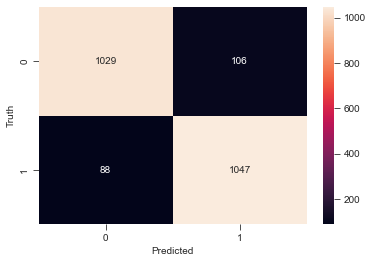

In [67]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [68]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      1135
           1       0.91      0.92      0.92      1135

    accuracy                           0.91      2270
   macro avg       0.91      0.91      0.91      2270
weighted avg       0.91      0.91      0.91      2270



In [98]:
model.save('C:/Users/acer/OneDrive/Desktop/BERT SMALL L4.h5')

PRE PROCESSED DATASET

In [68]:
#IT WORKS
my_reloaded_model = tf.keras.models.load_model(('C:/Users/acer/OneDrive/Desktop/BERT SMALL.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

In [4]:
df = pd.read_csv('C:/Users/acer/OneDrive/Desktop/MATERIALE TESI/DATASET/USA election Twitter collection/Preprocessed_dataset.csv')

In [84]:
#df = df.loc[(df["Day"]==2) | (df["Day"] == 4) | (df["Day"] == 6) | (df["Day"] == 8)]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475861 entries, 0 to 475860
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Screen_name  475861 non-null  object
 1   Retweet      316179 non-null  object
 2   Name         475848 non-null  object
 3   Text_clean   475860 non-null  object
 4   Day          475861 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 18.2+ MB


In [85]:
List_of_texts = df['Text_clean'].tolist()
List_of_texts

['Remember America Its About Freedom The Swamp BigTech leftist FakeNews WallStreet trying Silence Our Vo…',
 'RT WE ARE ONEnnthey ARE DONEnMIGAMAGAnTrump2020',
 'RT When Trump tries encourage confrontations violence coming days remember else hes absolute c…',
 'RT Do notice skin ’ crawl pays attention child Do notice difference With JoeBiden…',
 'RT The TrumpCaravan around WashingtonDC Capital Beltway Trump2020DCBeltway Straight Outta Bethesda MoCo DMV …',
 'RT MASSIVE Trump vehicle convoy brings Garden State Parkway standstill deeply blue New Jersey',
 'RT TONIGHT 7 pm EST hours LIVE w nn1 Will Barrett abandon Trump Election2020 goes …',
 'RT MAGA friends help find important things lost themlike smile hope amp couragennDo some…',
 'RT Biden quintessential politician establishment insider enriched amp family via VP status nnT…',
 'White women one key voter groups Election2020 many vote DonaldTrump l…',
 'Election2020 Straight Talk IF election results left Courts decide HIGHLY probable 

In [96]:
print("Start script " + str(datetime.datetime.now().time()))
array = model.predict(List_of_texts)
print("Finish script " + str(datetime.datetime.now().time()))

Start script 17:24:41.574825
Finish script 17:48:34.350288


In [99]:
array
column = pd.DataFrame(array)

In [105]:
column.shape

(475861, 1)

In [109]:
column = column.rename(columns={0:'Polarization Score'})
df = pd.concat([df,column],axis=1) 